# Prophet modeling

Here we'll try to mimic the same process of finding the best train-test split, but for Facebook's Prophet library. Let's import everything.

In [32]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
import pandas as pd
import matplotlib.pyplot as plt
import pandas.tseries
import datetime as dt
from datetime import date
from datetime import timedelta 
import yfinance as yf
import requests
from pandas.plotting import lag_plot
from pandas import datetime
import re
from tiingo import TiingoClient
import json
from pandas_datareader import data as pdr

In [2]:
yf.__version__

'0.1.63'

### The test case: C
Just like the previous notebook, we'll try to run through a simple test case and expand it to other stocks. We'll use Citicgroup again.

Quick note: I encountered a bug with my earlier library, yfinance, so I've had to switch to tiingo, so a lot of code will be hashed out from earlier. And in case I can get the bugs worked out.

In [3]:
c = yf.Ticker("C")

In [4]:
df=c.history(period="2y")

In [5]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-31,66.106543,66.347269,65.560281,65.884338,13617300,0.00,0
2019-08-01,65.430649,65.819509,62.588254,63.282650,22571000,0.00,0
2019-08-02,63.068111,63.487879,62.153943,63.068111,14771400,0.51,0
2019-08-05,61.193141,61.398363,60.241665,60.801357,21144800,0.00,0
2019-08-06,61.566267,61.874100,60.474867,61.799473,12411500,0.00,0


In [6]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-31,66.106543,66.347269,65.560281,65.884338,13617300,0.00,0
2019-08-01,65.430649,65.819509,62.588254,63.282650,22571000,0.00,0
2019-08-02,63.068111,63.487879,62.153943,63.068111,14771400,0.51,0
2019-08-05,61.193141,61.398363,60.241665,60.801357,21144800,0.00,0
2019-08-06,61.566267,61.874100,60.474867,61.799473,12411500,0.00,0


One of the data cleaning aspects of Prophet is that it requires the time periods to be in strings. I want to make this as simple as possible (i.e. just input a number), so here I'll look to transform some potential inputs into Prophet format.

In [7]:
deltas=['d','m','y']
att='200d'

In [8]:
att[-1]

'd'

In [9]:
spl=len(att)-1
att[:spl]

'200'

In [10]:
end=att[:spl] + ' days'
end

'200 days'

So let's get a dataframe with our close price so we can test modeling it.

In [11]:
df1=df['Close']

In [12]:
df1.head()

Date
2019-07-31    65.884338
2019-08-01    63.282650
2019-08-02    63.068111
2019-08-05    60.801357
2019-08-06    61.799473
Name: Close, dtype: float64

In [13]:
df1=df1.to_frame()

In [24]:
# instantiate Prophet
prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)

In [15]:
df1.head()

,Close
Date,
2019-07-31,65.884338
2019-08-01,63.282650
2019-08-02,63.068111
2019-08-05,60.801357
2019-08-06,61.799473


In [16]:
df1.index.names = ['ds']
df1.columns=['y']

In [17]:
df1.reset_index(level=0, inplace=True)

In [18]:
df1.head()

,ds,y
0,2019-07-31,65.884338
1,2019-08-01,63.282650
2,2019-08-02,63.068111
3,2019-08-05,60.801357
4,2019-08-06,61.799473


In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      505 non-null    datetime64[ns]
 1   y       505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


In [25]:
prof_1.fit(df1)

In [26]:
#Create a new dataframe for the predictions, 3 weeks out
future = prof_1.make_future_dataframe(periods=21)

In [27]:
forecast = prof_1.predict(future)

In [28]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
521,2021-08-16,73.840268,64.019970,73.829902,73.654478,74.120918,-4.812516,-4.812516,-4.812516,-3.320845,...,-0.065168,-0.065168,-0.065168,-1.426503,-1.426503,-1.426503,0.0,0.0,0.0,69.027753
522,2021-08-17,73.873535,63.849257,73.784509,73.662752,74.190638,-5.148499,-5.148499,-5.148499,-3.320845,...,-0.252670,-0.252670,-0.252670,-1.574983,-1.574983,-1.574983,0.0,0.0,0.0,68.725037
523,2021-08-18,73.906802,64.037532,73.532249,73.665290,74.258189,-5.178097,-5.178097,-5.178097,-3.320845,...,-0.141708,-0.141708,-0.141708,-1.715544,-1.715544,-1.715544,0.0,0.0,0.0,68.728705
524,2021-08-19,73.940069,63.792424,73.416011,73.656132,74.338782,-5.327706,-5.327706,-5.327706,-3.320845,...,-0.159635,-0.159635,-0.159635,-1.847226,-1.847226,-1.847226,0.0,0.0,0.0,68.612363
525,2021-08-20,73.973336,63.510420,73.073131,73.653368,74.419258,-5.501176,-5.501176,-5.501176,-3.320845,...,-0.211030,-0.211030,-0.211030,-1.969301,-1.969301,-1.969301,0.0,0.0,0.0,68.472160


In [29]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          526 non-null    datetime64[ns]
 1   trend                       526 non-null    float64       
 2   yhat_lower                  526 non-null    float64       
 3   yhat_upper                  526 non-null    float64       
 4   trend_lower                 526 non-null    float64       
 5   trend_upper                 526 non-null    float64       
 6   additive_terms              526 non-null    float64       
 7   additive_terms_lower        526 non-null    float64       
 8   additive_terms_upper        526 non-null    float64       
 9   daily                       526 non-null    float64       
 10  daily_lower                 526 non-null    float64       
 11  daily_upper                 526 non-null    float64       

In [30]:
proph_pred=forecast['yhat']

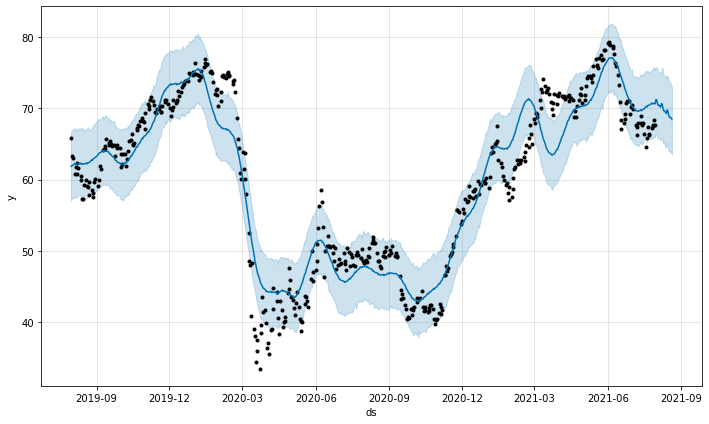

In [33]:
prof_1.plot(forecast)
plt.show()

Thankfully, Prophet has its own cross validation and performance metrics functions to see how well the model performed.

In [34]:
df1_cv = cross_validation(prof_1, initial='30 days', period='7 days', horizon = '14 days')

INFO:prophet:Making 99 forecasts with cutoffs between 2019-08-30 00:00:00 and 2021-07-16 00:00:00


  0%|          | 0/99 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [35]:
df1_pm = performance_metrics(df1_cv)

In [36]:
trains=['30 days','60 days','180 days']
tests=['7 days','14 days','21 days']

In [37]:
df1_pm.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
4,10 days,809.302073,28.448235,15.689433,0.264845,0.126876,0.267507,0.158119
5,11 days,1196.140716,34.585267,18.171550,0.305238,0.143579,0.296420,0.151515
6,12 days,1828.353465,42.759250,21.460524,0.360590,0.152915,0.331632,0.134021
7,13 days,2674.431869,51.714910,24.562173,0.404877,0.172101,0.357330,0.154639
8,14 days,3917.468680,62.589685,28.386475,0.458997,0.180299,0.381900,0.170049


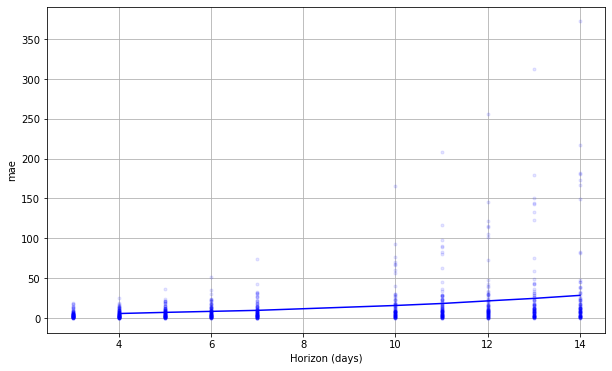

In [38]:
fig = plot_cross_validation_metric(df1_cv, metric='mae')

## STONKS (Again)!!!

Just like in the ARIMA notebook, I want to test a number of train-test splits with Prophet. Since it works a little different from ARIMA, the code will be a little different, but still borrowing a lot. Here, we can import our stock symbols, and clean them up.

In [39]:
sp_500=pd.read_csv('Data/constituents_csv.csv')
nsdq=pd.read_csv('Data/nasdaq.csv')
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

Again, we'll be doing the same things we did in the ARIMA notebook to make the data model-friendly. Like changing the names of the columns in the Dow dataframe.

In [41]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [42]:
nsdq.head()

,Unnamed: 0,Symbol,Company Name
0,1,AAL,"American Airlines Group, Inc."
1,2,AAME,Atlantic American Corporation
2,3,AAOI,"Applied Optoelectronics, Inc."
3,4,AAON,"AAON, Inc."
4,5,AAPL,Apple Inc.


In [43]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

In [44]:
len(nsdq)

1701

Again, like the ARIMA notebook, this code is to find all the bad stocks (delisted) in the NASDAQ csv file. I've hashed it out because I saved the csv, so it should work just fine. But I kept the code in case I run this in the future and it doesn't work.

In [37]:
#no_data=[]
#for each in nsdq['Symbol']:
#    x=yf.Ticker(each)
#    df=x.history(period='1d')
#    if len(df)==0:
#        no_data.append(each)

In [38]:
#len(no_data)

In [39]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [40]:
#nsdq = nsdq.drop(labels=nd_index,drop=True, axis=0)
#nsdq.reset_index()

In [41]:
#nsdq.to_csv("/Users/Daniel/Documents/Flatiron/Capstone/Project/nasdaq.csv")

In [49]:
def tt_test_p (asset,train_val,test_val):
    """This function will take in a financial asset (stock, etf) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run prophet models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='2y')
    print("Processing: ",stock)
    prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    future = prof_1.make_future_dataframe(periods=21)
    forecast = prof_1.predict(future)
    for train_val in trains:
        for test_val in tests:
            df1_cv = cross_validation(prof_1, initial=train_val, period=test_val, horizon = '21 days')
            df1_pm = performance_metrics(df1_cv)
            print('Training: ', train_val)
            print('Testing: ', test_val)
            print (df1_pm.tail())             

    return forecast

In [50]:
cols2=['Symbol','Train_Len','Test_Len','MAE','RMSE']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

,index,Symbol,Train_Len,Test_Len,MAE,RMSE


In [51]:
results_CAT=tt_test_p('CAT',trains,tests)

Processing:  yfinance.Ticker object <CAT>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-30 00:00:00 and 2021-07-09 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   45465.509440  213.226428   88.321916  0.667069  0.119665   
10 18 days   68900.605753  262.489249  105.921519  0.800742  0.132395   
11 19 days   83543.006821  289.038072  110.798174  0.842514  0.105496   
12 20 days  114877.140476  338.935304  128.615933  0.978416  0.133982   
13 21 days  153816.566692  392.194552  149.952836  1.129645  0.128458   

       smape  coverage  
9   0.400515  0.109815  
10  0.421310  0.111899  
11  0.420901  0.099653  
12  0.425569  0.115027  
13  0.449977  0.092199  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  25517.557545  159.742160   75.750888  0.579756  0.137769   
10 18 days  38741.505912  196.828621   89.974056  0.688709  0.144126   
11 19 days  50659.890176  225.077520   98.023506  0.749417  0.135365   
12 20 days  65732.013340  256.382553  109.664143  0.834475  0.163484   
13 21 days  86861.435090  294.722641  125.230307  0.941535  0.142231   

       smape  coverage  
9   0.419112  0.106383  
10  0.437427  0.117471  
11  0.438369  0.110089  
12  0.450943  0.102700  
13  0.469822  0.064099  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   34200.079216  184.932634   85.416077  0.642574  0.120290   
10 18 days   53517.719529  231.338971  103.706540  0.780020  0.128499   
11 19 days   70981.719807  266.423948  115.477330  0.871240  0.112519   
12 20 days   95742.172144  309.422320  129.696719  0.979291  0.113924   
13 21 days  127307.146666  356.801271  149.685826  1.123033  0.125183   

       smape  coverage  
9   0.499251  0.109043  
10  0.509981  0.093617  
11  0.513868  0.133462  
12  0.489346  0.154739  
13  0.521851  0.134973  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   34405.214724  185.486427   70.531952  0.517996  0.116899   
10 18 days   52337.663026  228.774262   83.703650  0.613489  0.111976   
11 19 days   61760.873303  248.517350   85.035623  0.625368  0.103742   
12 20 days   87136.500781  295.188924   99.304664  0.732670  0.115712   
13 21 days  118714.399197  344.549560  116.625941  0.851273  0.131499   

       smape  coverage  
9   0.335918  0.127799  
10  0.359629  0.114223  
11  0.360930  0.109132  
12  0.366846  0.124815  
13  0.392739  0.097507  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-18 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  21127.855429  145.354241   64.430338  0.479865  0.124849   
10 18 days  31573.415242  177.689097   75.059083  0.555240  0.132305   
11 19 days  40810.977049  202.017269   80.293493  0.591418  0.131926   
12 20 days  52739.666101  229.651184   89.271567  0.655932  0.127073   
13 21 days  69690.743928  263.990045  101.289445  0.737618  0.131895   

       smape  coverage  
9   0.364953  0.118627  
10  0.382526  0.107843  
11  0.382151  0.107947  
12  0.394774  0.121803  
13  0.411721  0.074468  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  28591.566298  169.090409   69.319943  0.506334  0.113363   
10 18 days  43421.775873  208.378924   81.614088  0.594911  0.102642   
11 19 days  56272.857814  237.219008   89.136299  0.651257  0.106493   
12 20 days  74276.023773  272.536280   97.430727  0.712206  0.124808   
13 21 days  97072.374641  311.564399  111.445299  0.806863  0.113147   

       smape  coverage  
9   0.394584  0.116667  
10  0.410783  0.122565  
11  0.418026  0.151760  
12  0.389606  0.164956  
13  0.423378  0.143939  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-02-07 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2070.237343  45.499861  28.061119  0.209714  0.074931  0.216393   
10 18 days  2674.310996  51.713741  30.854166  0.230870  0.093222  0.235033   
11 19 days  3096.416899  55.645457  32.791297  0.244995  0.093302  0.246751   
12 20 days  3559.351288  59.660299  34.658100  0.260857  0.101261  0.255592   
13 21 days  4100.917504  64.038406  37.004712  0.279524  0.103812  0.266439   

    coverage  
9   0.138156  
10  0.135705  
11  0.122488  
12  0.146770  
13  0.120364  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1883.150061  43.395277  29.538388  0.228624  0.116529  0.233741   
10 18 days  2196.501674  46.866850  31.493840  0.241798  0.095805  0.252015   
11 19 days  2405.538683  49.046291  32.642790  0.247989  0.104994  0.256891   
12 20 days  2653.539510  51.512518  34.111626  0.258819  0.111144  0.265035   
13 21 days  3031.331097  55.057525  36.080087  0.273067  0.119094  0.273320   

    coverage  
9   0.138889  
10  0.133838  
11  0.131579  
12  0.149761  
13  0.093780  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1661.878231  40.766141  27.089020  0.205312  0.085497  0.247943   
10 18 days  1994.033739  44.654605  28.584843  0.217891  0.104344  0.254426   
11 19 days  2112.512143  45.962073  28.988211  0.223745  0.105496  0.256346   
12 20 days  2326.569978  48.234531  29.814352  0.230253  0.111307  0.261670   
13 21 days  2624.171279  51.226666  31.793177  0.243156  0.095126  0.275392   

    coverage  
9   0.141622  
10  0.146886  
11  0.153846  
12  0.180873  
13  0.170478  


In [52]:
results_MMM=tt_test_p('MMM',trains,tests)

Processing:  yfinance.Ticker object <MMM>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-30 00:00:00 and 2021-07-09 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   49252.339721  221.928682   91.040606  0.577788  0.099813   
10 18 days   75364.388183  274.525751  110.508253  0.699186  0.112618   
11 19 days   96621.844518  310.840545  119.825790  0.760218  0.110185   
12 20 days  109137.987239  330.360390  127.862845  0.813207  0.118811   
13 21 days  162067.599871  402.576204  155.681266  0.981936  0.127554   

       smape  coverage  
9   0.343649  0.206131  
10  0.370468  0.178172  
11  0.379400  0.168838  
12  0.390835  0.173759  
13  0.408899  0.180851  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   44737.318727  211.511982   84.641389  0.544090  0.112531   
10 18 days   69514.140117  263.655343  102.290347  0.652284  0.112618   
11 19 days   92899.633931  304.794413  113.910953  0.725718  0.123298   
12 20 days  122799.733546  350.427929  129.622328  0.823988  0.127554   
13 21 days  164576.964168  405.680865  148.877707  0.935890  0.129409   

       smape  coverage  
9   0.344154  0.191489  
10  0.369318  0.172011  
11  0.383467  0.151480  
12  0.402907  0.157864  
13  0.400872  0.184248  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   85827.916663  292.964019  116.645173  0.733243  0.092613   
10 18 days  133670.195265  365.609348  144.175401  0.902675  0.115787   
11 19 days  176422.489123  420.026772  162.493620  1.019794  0.131694   
12 20 days  174920.478004  418.234956  151.784624  0.953725  0.131694   
13 21 days  282984.794201  531.963151  197.820754  1.238245  0.133759   

       smape  coverage  
9   0.459681  0.283245  
10  0.476672  0.228369  
11  0.484191  0.148291  
12  0.459527  0.166344  
13  0.492199  0.166223  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   44984.717966  212.096011   81.338421  0.514558  0.096833   
10 18 days   69347.645187  263.339411   98.372370  0.619178  0.091130   
11 19 days   89049.666977  298.411908  105.702662  0.666550  0.109714   
12 20 days   98979.424188  314.609956  111.310749  0.703660  0.112362   
13 21 days  150749.416298  388.264621  137.373065  0.860835  0.119267   

       smape  coverage  
9   0.309011  0.222439  
10  0.334117  0.180597  
11  0.341204  0.167148  
12  0.350444  0.179761  
13  0.366414  0.190996  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-18 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   45880.258077  214.196774   83.760178  0.536491  0.111697   
10 18 days   71176.888283  266.789970  100.672978  0.638538  0.111339   
11 19 days   95100.150406  308.383123  111.710765  0.707455  0.113889   
12 20 days  125684.354681  354.519893  126.937713  0.802269  0.125638   
13 21 days  168725.471026  410.762061  145.739052  0.911655  0.117572   

       smape  coverage  
9   0.339473  0.207516  
10  0.361159  0.179412  
11  0.373087  0.158010  
12  0.390730  0.164642  
13  0.385849  0.207134  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   87751.941143  296.229541  112.625811  0.703871  0.113790   
10 18 days  136004.674177  368.788116  137.967263  0.859397  0.086382   
11 19 days  178896.096645  422.961105  154.669377  0.965883  0.100078   
12 20 days  173822.077043  416.919749  139.665628  0.872564  0.134931   
13 21 days  284982.420242  533.837447  185.110148  1.152271  0.118849   

       smape  coverage  
9   0.417634  0.280303  
10  0.435485  0.232955  
11  0.443046  0.180352  
12  0.413730  0.164956  
13  0.446235  0.166667  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-02-07 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2536.692933  50.365593  26.955069  0.181183  0.070099  0.189648   
10 18 days  3164.803626  56.256587  29.348222  0.194966  0.084146  0.211340   
11 19 days  3598.331227  59.986092  31.372808  0.207230  0.087886  0.227302   
12 20 days  4091.951441  63.968363  32.938806  0.219083  0.086852  0.236913   
13 21 days  4496.669784  67.057213  33.671601  0.224922  0.083611  0.230535   

    coverage  
9   0.263380  
10  0.226087  
11  0.210526  
12  0.230622  
13  0.239636  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  3083.389431  55.528276  31.216615  0.217690  0.083105  0.223205   
10 18 days  3590.862582  59.923806  32.962680  0.225180  0.089080  0.241141   
11 19 days  3897.204236  62.427592  34.433979  0.231847  0.087122  0.255033   
12 20 days  4134.433652  64.299562  35.469185  0.239087  0.087122  0.263411   
13 21 days  4265.042230  65.307291  34.882471  0.234673  0.103858  0.239098   

    coverage  
9   0.250000  
10  0.222727  
11  0.210526  
12  0.210526  
13  0.240191  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1960.404596  44.276456  25.297173  0.168049  0.056004  0.235813   
10 18 days  2500.862721  50.008626  28.227426  0.187341  0.069829  0.264266   
11 19 days  2805.873919  52.970500  30.221191  0.202388  0.093501  0.277932   
12 20 days  3090.528984  55.592526  31.385610  0.212663  0.059998  0.284481   
13 21 days  3522.036375  59.346747  33.556980  0.227074  0.063081  0.294707   

    coverage  
9   0.340541  
10  0.279671  
11  0.188150  
12  0.180873  
13  0.197505  


In [53]:
results_AXP=tt_test_p('AXP',trains,tests)

Processing:  yfinance.Ticker object <AXP>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-30 00:00:00 and 2021-07-09 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days  14086.669885  118.687278  58.001244  0.523002  0.131423  0.388560   
10 18 days  21637.260167  147.096092  69.968551  0.623951  0.138342  0.416335   
11 19 days  26286.387762  162.130774  72.911967  0.649345  0.130519  0.417486   
12 20 days  35738.682395  189.046773  83.065813  0.732832  0.150565  0.430097   
13 21 days  50162.178950  223.969147  98.114405  0.855034  0.147724  0.445356   

    coverage  
9   0.158316  
10  0.157526  
11  0.186858  
12  0.197917  
13  0.180851  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  18355.477902  135.482390   67.029933  0.618624  0.131687   
10 18 days  28423.580908  168.592944   81.931525  0.740501  0.137817   
11 19 days  34966.263050  186.992682   86.634264  0.774905  0.142172   
12 20 days  49339.441860  222.124834  101.819615  0.896939  0.143968   
13 21 days  68131.991418  261.021056  118.359191  1.026039  0.129305   

       smape  coverage  
9   0.439677  0.198681  
10  0.463204  0.186095  
11  0.457675  0.186260  
12  0.470869  0.198944  
13  0.468860  0.198620  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days  17211.454014  131.192431  57.867306  0.501724  0.131423  0.411312   
10 18 days  26383.005720  162.428463  69.053051  0.598492  0.137817  0.433480   
11 19 days  34565.585908  185.918224  76.435826  0.662504  0.138342  0.443738   
12 20 days  41503.611307  203.724351  77.094040  0.664002  0.132250  0.416347   
13 21 days  58394.425748  241.649386  93.640401  0.801976  0.142894  0.451518   

    coverage  
9   0.131649  
10  0.136170  
11  0.151515  
12  0.176015  
13  0.187500  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days  12578.212798  112.152632  51.537322  0.466288  0.120596  0.349214   
10 18 days  19465.910688  139.520288  62.041135  0.553718  0.129133  0.370866   
11 19 days  23396.862151  152.960329  63.588463  0.566650  0.119514  0.367350   
12 20 days  32129.942071  179.248269  72.449146  0.638640  0.132945  0.377424   
13 21 days  45845.947884  214.116669  86.278779  0.749862  0.153086  0.390540   

    coverage  
9   0.163501  
10  0.173661  
11  0.200449  
12  0.201329  
13  0.187305  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-18 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  16274.260463  127.570610   60.146131  0.557781  0.130312   
10 18 days  25275.542092  158.982836   73.289085  0.662716  0.130089   
11 19 days  30692.908136  175.193916   76.369685  0.682890  0.130636   
12 20 days  44011.768188  209.789819   90.347670  0.794658  0.122462   
13 21 days  61345.447040  247.680130  105.091141  0.908292  0.128882   

       smape  coverage  
9   0.400681  0.215033  
10  0.423977  0.208824  
11  0.416822  0.201189  
12  0.429538  0.207481  
13  0.424529  0.207447  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days  17750.087717  133.229455  55.379241  0.479438  0.129494  0.378828   
10 18 days  27168.511869  164.828735  65.685808  0.568729  0.129133  0.382443   
11 19 days  35569.699153  188.599308  72.510659  0.628150  0.122960  0.383853   
12 20 days  42589.113103  206.371299  71.823806  0.618074  0.147756  0.348980   
13 21 days  60184.300411  245.324887  88.145913  0.753173  0.127419  0.383877   

    coverage  
9   0.140909  
10  0.145292  
11  0.161290  
12  0.187683  
13  0.222727  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-02-07 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1535.152375  39.181021  21.942448  0.223113  0.098633  0.224523   
10 18 days  1761.260249  41.967371  23.405326  0.233210  0.120341  0.234738   
11 19 days  1869.194122  43.234178  23.889423  0.234615  0.121759  0.237534   
12 20 days  2055.991903  45.343047  24.541133  0.239873  0.105519  0.240854   
13 21 days  1755.746982  41.901635  23.396831  0.227656  0.109099  0.228410   

    coverage  
9   0.207426  
10  0.203689  
11  0.228708  
12  0.229904  
13  0.225818  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2352.221248  48.499704  25.538428  0.277118  0.107410  0.257083   
10 18 days  2749.309460  52.433858  27.593200  0.285750  0.097167  0.269017   
11 19 days  2976.552674  54.557792  28.566682  0.283590  0.120093  0.272915   
12 20 days  3276.171873  57.237853  29.308084  0.286016  0.111455  0.274065   
13 21 days  2703.747535  51.997572  26.923036  0.258704  0.126379  0.246228   

    coverage  
9   0.259596  
10  0.240909  
11  0.218660  
12  0.228708  
13  0.249761  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  555.120214  23.560989  16.832987  0.156534  0.111669  0.194101   
10 18 days  587.172802  24.231649  17.601647  0.166106  0.125827  0.208128   
11 19 days  640.658697  25.311237  18.216127  0.174179  0.130579  0.215434   
12 20 days  684.251819  26.158207  18.559973  0.176363  0.108045  0.217047   
13 21 days  778.784928  27.906718  19.957603  0.188736  0.103753  0.230233   

    coverage  
9   0.171892  
10  0.173913  
11  0.192308  
12  0.219335  
13  0.264033  


In [54]:
results_AAPL=tt_test_p('AAPL',trains,tests)

Processing:  yfinance.Ticker object <AAPL>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-30 00:00:00 and 2021-07-09 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days   3495.641560   59.123951  26.824955  0.388775  0.089136  0.290572   
10 18 days   5219.168843   72.243815  31.740609  0.462548  0.097715  0.306284   
11 19 days   6027.764211   77.638677  33.092847  0.485765  0.107309  0.312821   
12 20 days   8421.880535   91.770804  37.857643  0.557552  0.108898  0.319541   
13 21 days  11364.759671  106.605627  43.482016  0.642956  0.096995  0.336772   

    coverage  
9   0.143445  
10  0.132861  
11  0.134535  
12  0.121232  
13  0.117021  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1736.837386  41.675381  20.931506  0.288467  0.083634  0.247164   
10 18 days  2519.775372  50.197364  24.261737  0.333995  0.104739  0.261240   
11 19 days  3291.926233  57.375310  26.940223  0.372909  0.096530  0.275456   
12 20 days  4219.163324  64.955087  29.358867  0.409994  0.101086  0.286792   
13 21 days  5434.829729  73.721298  31.695763  0.446350  0.096995  0.282547   

    coverage  
9   0.191789  
10  0.179503  
11  0.129922  
12  0.116784  
13  0.141707  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days   917.622552  30.292285  17.430370  0.231713  0.090221  0.266016   
10 18 days  1420.445756  37.688801  20.757463  0.280592  0.093810  0.287640   
11 19 days  1887.780830  43.448600  23.139172  0.317325  0.104739  0.309136   
12 20 days  2433.500195  49.330520  24.473673  0.338329  0.104833  0.288580   
13 21 days  3364.167397  58.001443  28.624801  0.401756  0.101086  0.329964   

    coverage  
9   0.119016  
10  0.146099  
11  0.108962  
12  0.092843  
13  0.072473  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2604.369926  51.033028  22.463208  0.304130  0.086361  0.235942   
10 18 days  3905.591696  62.494733  26.303134  0.358117  0.093700  0.251857   
11 19 days  4319.586347  65.723560  26.764545  0.365475  0.095586  0.256856   
12 20 days  6281.810877  79.257876  30.637765  0.420477  0.089125  0.260866   
13 21 days  8692.901256  93.235730  35.238169  0.486448  0.098732  0.274564   

    coverage  
9   0.151883  
10  0.140211  
11  0.134409  
12  0.124405  
13  0.131048  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-18 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1741.609471  41.732595  20.528533  0.277378  0.084154  0.241656   
10 18 days  2510.295260  50.102847  23.562107  0.316811  0.105301  0.252084   
11 19 days  3271.523873  57.197237  25.973762  0.350659  0.100635  0.262677   
12 20 days  4186.212215  64.700944  28.113638  0.382929  0.095159  0.270125   
13 21 days  5394.383814  73.446469  30.106740  0.413564  0.088843  0.259715   

    coverage  
9   0.192810  
10  0.187255  
11  0.150188  
12  0.128517  
13  0.147997  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days   604.238403  24.581261  14.971676  0.184432  0.089743  0.211638   
10 18 days   896.284190  29.938006  17.373607  0.216754  0.089645  0.235191   
11 19 days  1158.511388  34.036912  19.001902  0.239896  0.088706  0.255660   
12 20 days  1389.949648  37.282028  19.209765  0.241109  0.107254  0.227609   
13 21 days  1925.643865  43.882159  22.307943  0.285959  0.103301  0.264579   

    coverage  
9   0.127273  
10  0.155844  
11  0.115836  
12  0.098974  
13  0.077273  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-02-07 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  7 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  440.568367  20.989721  12.705453  0.147589  0.067783  0.146539   
10 18 days  511.134603  22.608286  13.684254  0.156498  0.086361  0.153807   
11 19 days  556.593844  23.592241  14.170446  0.161506  0.077895  0.157867   
12 20 days  596.479426  24.422928  14.538582  0.166244  0.064337  0.161623   
13 21 days  591.238941  24.315405  14.509627  0.165276  0.070217  0.153465   

    coverage  
9   0.187836  
10  0.162846  
11  0.157895  
12  0.159330  
13  0.165818  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  14 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  684.434492  26.161699  14.770424  0.184412  0.081998  0.181163   
10 18 days  776.418227  27.864282  15.770075  0.191645  0.082768  0.185757   
11 19 days  835.735523  28.909091  16.173871  0.194344  0.067131  0.186862   
12 20 days  882.406962  29.705336  16.325194  0.195827  0.067131  0.186651   
13 21 days  829.457069  28.800296  15.472635  0.182299  0.066854  0.159809   

    coverage  
9   0.251010  
10  0.214141  
11  0.155981  
12  0.167943  
13  0.194258  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  181.177567  13.460222  10.786183  0.111697  0.081998  0.117427   
10 18 days  223.788371  14.959558  11.689740  0.120948  0.075855  0.127098   
11 19 days  255.120827  15.972502  12.313585  0.129408  0.071526  0.133890   
12 20 days  263.910249  16.245315  12.510226  0.132313  0.064848  0.135315   
13 21 days  317.457729  17.817343  13.544106  0.144432  0.070806  0.147115   

    coverage  
9   0.153514  
10  0.186839  
11  0.138254  
12  0.088358  
13  0.079002  


In [55]:
results_AMGN=tt_test_p('AMGN',trains,tests)

Processing:  yfinance.Ticker object <AMGN>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-30 00:00:00 and 2021-07-09 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   89723.143977  299.538218  124.907572  0.604901  0.086061   
10 18 days  139499.362548  373.496135  152.646143  0.737000  0.085921   
11 19 days  181238.496697  425.721149  165.000349  0.801002  0.084437   
12 20 days  245791.758653  495.773899  192.180728  0.930052  0.073352   
13 21 days  330332.912306  574.745955  226.736308  1.089780  0.105502   

       smape  coverage  
9   0.333847  0.221002  
10  0.345659  0.209929  
11  0.337664  0.196049  
12  0.341419  0.208777  
13  0.368909  0.195035  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-09-06 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days  107134.116483  327.313484  139.859482  0.672420  0.086061   
10 18 days  166409.681135  407.933427  172.155084  0.825651  0.084063   
11 19 days  219151.758769  468.136475  189.641925  0.913182  0.111382   
12 20 days  292077.174238  540.441647  219.974567  1.055809  0.105502   
13 21 days  394262.003991  627.902862  260.915367  1.245928  0.112804   

       smape  coverage  
9   0.333503  0.198681  
10  0.343287  0.228349  
11  0.338200  0.220178  
12  0.352332  0.247653  
13  0.377630  0.248347  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days  100888.585756  317.629636  120.340720  0.576988  0.046803   
10 18 days  157090.902342  396.346947  148.704706  0.713319  0.086575   
11 19 days  207575.945829  455.605033  168.185797  0.810028  0.080053   
12 20 days  278773.401352  527.989963  189.366134  0.917790  0.073316   
13 21 days  369293.520678  607.695253  221.621217  1.073166  0.109370   

       smape  coverage  
9   0.300053  0.230718  
10  0.311738  0.219858  
11  0.319082  0.221148  
12  0.291418  0.216634  
13  0.328068  0.218750  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   62966.601423  250.931468   94.312003  0.439106  0.086069   
10 18 days   97854.126245  312.816442  113.659321  0.526217  0.067911   
11 19 days  125449.318371  354.188253  119.362583  0.554093  0.085179   
12 20 days  172142.315202  414.900368  139.257721  0.644043  0.074648   
13 21 days  233955.251182  483.689209  165.487791  0.759416  0.079448   

       smape  coverage  
9   0.258305  0.226594  
10  0.265633  0.217910  
11  0.256897  0.206789  
12  0.259120  0.220190  
13  0.285229  0.213548  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-18 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   66985.868793  258.816284  102.711480  0.471560  0.079415   
10 18 days  104772.525099  323.685843  125.542400  0.572894  0.084250   
11 19 days  137566.052271  370.898979  135.623640  0.620098  0.086518   
12 20 days  187503.579396  433.016835  159.131974  0.726096  0.098880   
13 21 days  258503.984884  508.432872  190.618265  0.865673  0.110234   

       smape  coverage  
9   0.271269  0.207516  
10  0.281015  0.238235  
11  0.274646  0.229662  
12  0.289058  0.243606  
13  0.312377  0.251877  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  60 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   49702.582887  222.940761   68.673874  0.301096  0.051495   
10 18 days   75990.095097  275.663010   82.499629  0.360814  0.067145   
11 19 days   99492.652164  315.424559   92.313643  0.405161  0.069553   
12 20 days  131995.529304  363.311890   99.170615  0.436140  0.067638   
13 21 days  175559.354786  418.998037  117.314446  0.514602  0.070392   

       smape  coverage  
9   0.227201  0.246970  
10  0.233763  0.234578  
11  0.239948  0.235337  
12  0.205139  0.230938  
13  0.240502  0.210606  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-02-07 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1491.386976  38.618480  21.792173  0.100315  0.054039  0.095183   
10 18 days  1688.745928  41.094354  22.907295  0.104696  0.060572  0.100340   
11 19 days  1844.197776  42.944124  23.947708  0.109196  0.071614  0.105094   
12 20 days  1992.026771  44.632127  24.498781  0.112290  0.072956  0.107834   
13 21 days  2185.130721  46.745382  25.308412  0.116241  0.068512  0.111483   

    coverage  
9   0.284379  
10  0.280632  
11  0.253110  
12  0.275359  
13  0.249455  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-31 00:00:00 and 2021-07-09 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2321.775753  48.184808  26.491331  0.124039  0.066650  0.108685   
10 18 days  2592.273275  50.914372  27.074032  0.125716  0.077383  0.109866   
11 19 days  2756.311085  52.500582  27.400927  0.127427  0.066410  0.110576   
12 20 days  2938.543208  54.208332  27.877334  0.130752  0.056664  0.111920   
13 21 days  3290.739594  57.364968  29.150865  0.137058  0.077331  0.115892   

    coverage  
9   0.259596  
10  0.277273  
11  0.271292  
12  0.317703  
13  0.324402  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  491.981291  22.180651  16.002074  0.070486  0.046599  0.072521   
10 18 days  565.594901  23.782239  17.095322  0.075000  0.062193  0.077741   
11 19 days  623.233894  24.964653  18.408892  0.080973  0.065279  0.083681   
12 20 days  580.613759  24.095928  18.283837  0.081023  0.056962  0.083105   
13 21 days  661.445632  25.718585  19.358602  0.084962  0.057405  0.087896   

    coverage  
9   0.301622  
10  0.280846  
11  0.280665  
12  0.269231  
13  0.222453  


After looking over these results, it seems unlike ARIMA, Prophet likes the 180/7 split. 

### Putting it all together

So let's make us a function! Ultimately, we'll want it to be able to select the best of 4 stocks input by the user. As always, let's start simple.

In [56]:
results_AMGN.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
521,2021-08-16,233.342122,227.697122,244.440196,232.643566,233.838381,2.623248,2.623248,2.623248,-4.620674,...,-0.199287,-0.199287,-0.199287,7.443208,7.443208,7.443208,0.0,0.0,0.0,235.965370
522,2021-08-17,233.239441,228.747857,244.740630,232.433127,233.798239,3.309261,3.309261,3.309261,-4.620674,...,-0.056544,-0.056544,-0.056544,7.986479,7.986479,7.986479,0.0,0.0,0.0,236.548702
523,2021-08-18,233.136760,229.076218,244.642461,232.263854,233.791855,3.655113,3.655113,3.655113,-4.620674,...,-0.265430,-0.265430,-0.265430,8.541217,8.541217,8.541217,0.0,0.0,0.0,236.791873
524,2021-08-19,233.034079,228.744768,244.873841,232.061439,233.734145,3.924318,3.924318,3.924318,-4.620674,...,-0.545394,-0.545394,-0.545394,9.090386,9.090386,9.090386,0.0,0.0,0.0,236.958397
525,2021-08-20,232.931398,229.877504,245.866019,231.857844,233.702188,4.907835,4.907835,4.907835,-4.620674,...,-0.088513,-0.088513,-0.088513,9.617022,9.617022,9.617022,0.0,0.0,0.0,237.839233


In [57]:
pred_cols=['ds','yhat']

In [58]:
AMGN_preds=results_AMGN[pred_cols]

In [59]:
AMGN_preds.tail()

,ds,yhat
521,2021-08-16,235.965370
522,2021-08-17,236.548702
523,2021-08-18,236.791873
524,2021-08-19,236.958397
525,2021-08-20,237.839233


In [60]:
AMGN_preds=AMGN_preds.tail(21)

In [61]:
AMGN_preds.head()

,ds,yhat
505,2021-07-31,240.249385
506,2021-08-01,239.350658
507,2021-08-02,237.737983
508,2021-08-03,237.120376
509,2021-08-04,236.237542


In [62]:
AMGN_preds.reset_index(level=0, drop=True,inplace=True)

In [63]:
AMGN_preds.head()

,ds,yhat
0,2021-07-31,240.249385
1,2021-08-01,239.350658
2,2021-08-02,237.737983
3,2021-08-03,237.120376
4,2021-08-04,236.237542


In [64]:
AMGN_preds['yhat'][20]

237.8392332526495

In [65]:
AMGN_preds['yhat'][0]

240.2493854778314

In [66]:
change_percent=((AMGN_preds['yhat'][20]-AMGN_preds['yhat'][0])/AMGN_preds['yhat'][0])*100

In [69]:
change_percent=round(change_percent,3)

In [70]:
change_percent

-1.0

Now let's put this together into a simple function. It will take the yhat predictions and calculate the percentage return.

In [71]:
def pct_change(df):
    """This function will quickly calculate the percentage change from the predictions dataframe.
    One that has been produced from the earlier Prophet function"""
    df1=df['yhat']
    df1=df1.tail(21)
    df1.reset_index(level=0, drop=True,inplace=True)
    change=((df1[20]-df1[0])/df1[0])*100
    change=round(change, 2)
    if change >0:
        print(f"According to the model, you stand to gain {change}% over the next 21 days")
    else:
        change_abs=abs(change)
        print(f"According to the model, you stand to lose {change_abs}% over the next 21 days")
    return None

In [72]:
pct_change(results_AAPL)

According to the model, you stand to gain 6.29% over the next 21 days


In [73]:
pct_change(results_AXP)

According to the model, you stand to gain 3.32% over the next 21 days


In [74]:
pct_change(results_MMM)

According to the model, you stand to lose 1.23% over the next 21 days


In [75]:
pct_change(results_CAT)

According to the model, you stand to lose 5.97% over the next 21 days


Now, let's create a function that will run through the Prophet process, and return the forecast.

In [76]:
def fcast(stock):
    """This function will take a stock and perform Prophet modeling on it and return the forecast dataframe"""
    stock=stock.upper() #make sure the symbol is in uppercase
    prof=Prophet(daily_seasonality=True, yearly_seasonality=True)
    stonk = yf.Ticker(stock)
    df1=stonk.history(period='1y')
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof.fit(df1)
    future = prof.make_future_dataframe(periods=21)
    forecast = prof.predict(future)
    #The next 2 lines are disabled for the final function, but I wanted a few graphs.
#    prof.plot(forecast)
 #   plt.show()
    return forecast

In [77]:
HAL=fcast('HAL')

In [78]:
HAL.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-31,14.439765,13.464297,15.159303,14.439765,14.439765,-0.103747,-0.103747,-0.103747,1.013733,...,0.002635,0.002635,0.002635,-1.120115,-1.120115,-1.120115,0.0,0.0,0.0,14.336018
1,2020-08-03,14.495030,13.853417,15.545039,14.495030,14.495030,0.222052,0.222052,0.222052,1.013733,...,0.033971,0.033971,0.033971,-0.825652,-0.825652,-0.825652,0.0,0.0,0.0,14.717082
2,2020-08-04,14.513452,14.027060,15.628014,14.513452,14.513452,0.344179,0.344179,0.344179,1.013733,...,0.052593,0.052593,0.052593,-0.722147,-0.722147,-0.722147,0.0,0.0,0.0,14.857630
3,2020-08-05,14.531873,14.244814,15.926586,14.531873,14.531873,0.539834,0.539834,0.539834,1.013733,...,0.144273,0.144273,0.144273,-0.618172,-0.618172,-0.618172,0.0,0.0,0.0,15.071707
4,2020-08-06,14.550295,14.257534,15.929364,14.550295,14.550295,0.518735,0.518735,0.518735,1.013733,...,0.019962,0.019962,0.019962,-0.514960,-0.514960,-0.514960,0.0,0.0,0.0,15.069030


In [79]:
MMM=fcast('MMM')

In [80]:
AXP=fcast('AXP')

Now the final piece: taking in 4 stocks from the user, running them through the previous functions, and letting us know which one stands to gain the most.

In [83]:
def pred_4():
    """This function will prompt the user to input 4 different stock/ETF symbols. It will then use Prophet 
    to forecast the next 21 days of the stock price, and return the values (in percent) of potential gain and loss."""
    stocks=[]
    pcts=[]
    stock1,stock2,stock3,stock4=input("Enter 4 stock symbols: ").split(",")
    stocks=[stock1,stock2,stock3,stock4]
    print("Working...")
    for stock in stocks:
        stock=stock.upper()
        df=fcast(stock)
        df1=df['yhat']
        df1=df1.tail(21)
        df1.reset_index(level=0, drop=True,inplace=True)
        change=((df1[20]-df1[0])/df1[0])*100
        change=round(change, 2)
        pcts.append(change)
    for i in range(0,4):
        print(f"Stock: {stocks[i].upper()}")
        print(f"Percent Change: {pcts[i]}")
    maxp=pcts.index(max(pcts))
    print()
    print(f'According to the model, {stocks[maxp].upper()} has the highest upside.')
    print("\n" * 3)
    print('FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.') 
    print('The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.')
    return None
    

In [84]:
pred_4()

Enter 4 stock symbols: aal,f,fb,t
Working...
Stock: AAL
Percent Change: 7.18
Stock: F
Percent Change: 1.93
Stock: FB
Percent Change: 6.32
Stock: T
Percent Change: 0.35

According to the model, AAL has the highest upside.




FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.
The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.


# Conclusion:

I like to call this the KISSSS (the Keep it Simple Stock Selector-The Last 'S' is a typo), and it's true to its name. It's simple, it provides an answer that investors can use to make their decisions. Now as the disclaimer states, this should not be the only factor used in making any investment decision; but for someone that doesn't want to do a lot of research into their stock purchases, this will fit them just fine.

Personaly, I like Prophet much better than ARIMA. It provided much better numbers and it was built to predict time series that were more random than what ARIMA was built for.